# MDP

In [0]:
from IPython.display import clear_output

## On réprésente un MDP comme une instance de la classe suivante
class MDP:
  def __init__(self):
    self.states = []
    self.actions = []
    self.T = {} # un dictionnaire de type "{(s,a,s') : proba de la transition(s,a,s')}"
    self.R = {} # un dictionnaire de type "{(s,a,s') : récompense de la transition(s,a,s')}"
  
## value iteration 
# INPUT : un MDP M, un facteur de dépréciation gamma et un nombre d'itérations B
# OUTPUT : la fonction de valeur optimale, représentée comme un dictionnaire du type "{state: V^*(state)}"
def value_iteration(M, gamma):
    V = {s: 0 for s in M.states}
    while(True):
        var = 0
        for s in V:
            old = V[s]
            V[s] = max([sum(([M.T[(s,a,s2)]*(M.R[(s,a,s2)] + gamma*V[s2]) for s2 in M.states])) for a in M.actions])
            var += abs(V[s]-old)
        if var/len(V) == 0:
          break
    return V

## optimal policy
# INPUT : un MDP M, la fonction de valeur optimal V^*, le facteur de dépréciation gamma
# OUTPUT : une politique optimale, donnée comme un dictionnaire du type {state: action}
def optimal_policy(M, V, gamma):
    pi = {s:0 for s in M.states}
    for s in M.states:
        temp = [(sum([M.T[s,a,s2]*(M.R[s,a,s2] + gamma*V[s2]) for s2 in M.states]),a) for a in M.actions]
        pi[s] = max(temp,key = lambda x: x[0])[1]
    return pi

# Test code

In [0]:
import matplotlib.pyplot as plt

def run(env, mdp, optimal, episodes, render=False, tracer=True):
  Y1 = []
  Y2 = []
  for i_episode in range(episodes):
    state = mdp.box_to_state(env.reset())
    R = 0
    for t in range(200):
      if render:
        env.render()
      action = optimal[state]
      next_state, reward, done, info = env.step(action)
      state = mdp.box_to_state(next_state)
      R += reward
      if done:
        Y1 += [R]
        moy = sum([Y1[-j] for j in range(1,i_episode+1)])/(i_episode+1)
        Y2 += [moy]
        #print("Ep {} / Ts {} / Rw {} / My {}".format(i_episode,t+1,R,moy))
        break
  if tracer:
    plt.plot(range(len(Y1)), Y1, 'b+')
    #plt.plot(range(len(Y2)), Y2, 'r-')
    plt.show()
    plt.close()
    print (sum([Y1[j] for j in range(0,i_episode+1)])/(i_episode))
  env.close()

# MountainCar


In [0]:
import numpy as np
import math

min_position = -1.2
max_position = 0.6
max_speed = 0.07
goal_position = 0.5
force=0.001
gravity=0.0025

class MountainCarMDP:
  def __init__(self, pos_size=9, vel_size=14, pos_samples=51, vel_samples=51):
    self.pos_size = pos_size
    self.vel_size = vel_size
    self.pos_samples = pos_samples
    self.vel_samples = vel_samples
    self.pos_space = np.linspace(-1.2, 0.6, self.pos_size+1, endpoint=True)
    self.vel_space = np.linspace(-0.07, 0.07, self.vel_size+1, endpoint=True)
    self.states = [(i,j) for i in range(pos_size) for j in range(vel_size)] # (pos, vel)
    self.actions = [0, 2]                                        
    self.T = {(s,a,s2):0 for s in self.states for a in self.actions for s2 in self.states}
    self.R = {(s,a,s2):0 for s in self.states for a in self.actions for s2 in self.states}
    self.init_R()
    self.init_T()

  def box_to_state(self, box):
    pos, vel = box
    pos_bin = np.digitize(pos, self.pos_space, right=True)-1
    if pos_bin < 0:
      pos_bin = 0
    vel_bin = np.digitize(vel, self.vel_space, right=True)-1
    if vel_bin < 0:
      vel_bin = 0
    return (pos_bin, vel_bin)

  def state_to_range(self, state):
    pos, vel = state
    return (self.pos_space[pos], self.pos_space[pos+1], self.vel_space[vel], self.vel_space[vel+1])

  def init_R(self):
    for state in self.states:
      for next_state in self.states:  
        for action in self.actions: 
          _, position, _, _ = self.state_to_range(next_state)
          if ( position >= 0.5):
            self.R[state,action,next_state] = 1

  def init_T(self):
    for state in self.states:    
      pos_min, pos_max, vel_min, vel_max = self.state_to_range(state)
      for state_tmp in [(s,a) for s in np.linspace(pos_min, pos_max, self.pos_samples) for a in np.linspace(vel_min, vel_max, self.vel_samples)]:
        for action in self.actions: 
          position, velocity = state_tmp
          velocity += (action-1)*force + math.cos(3*position)*(-gravity)
          velocity = np.clip(velocity, -max_speed, max_speed)
          position += velocity
          position = np.clip(position, min_position, max_position)
          if (position==min_position and velocity<0): velocity = 0
          next_state = (position, velocity)
          next_state = self.box_to_state(next_state)
          self.T[state,action,next_state] += 1/(self.pos_samples*self.vel_samples)


# Run

In [476]:
# position intervals
np.linspace(-1.2, 0.6, 9+1)

array([-1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6])

In [477]:
# exemple of samples generated for a position interval
np.linspace( 0.0, 0.2, 51)

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  ])

In [478]:
# velocity intervals
np.linspace(-0.07, 0.07, 14+1)

array([-0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,
        0.02,  0.03,  0.04,  0.05,  0.06,  0.07])

In [479]:
# exemple of samples generated for a velocity interval
np.linspace( 0.0 , 0.01, 51)

array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
       0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026, 0.0028, 0.003 ,
       0.0032, 0.0034, 0.0036, 0.0038, 0.004 , 0.0042, 0.0044, 0.0046,
       0.0048, 0.005 , 0.0052, 0.0054, 0.0056, 0.0058, 0.006 , 0.0062,
       0.0064, 0.0066, 0.0068, 0.007 , 0.0072, 0.0074, 0.0076, 0.0078,
       0.008 , 0.0082, 0.0084, 0.0086, 0.0088, 0.009 , 0.0092, 0.0094,
       0.0096, 0.0098, 0.01  ])

In [0]:
MountainCar = MountainCarMDP(pos_size=9, vel_size=14, pos_samples=51, vel_samples=51)

In [0]:
gamma = 0.9
V = value_iteration(MountainCar, gamma)
O = optimal_policy(MountainCar, V, gamma)

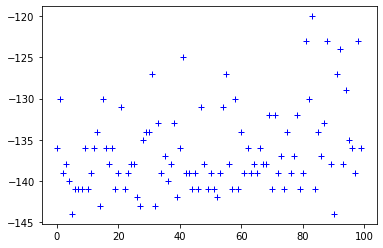

-137.73737373737373


In [488]:
import gym
env = gym.make('MountainCar-v0')
run(env, MountainCar, O, 100)